## Faster VoxelPose: Visualization Demo

This is a visualization demo using our pre-trained models to test on RGB images with the batch size of 1. You can visualize the results of multi-person pose predictions for your customized sequences.

### Prepare
Check environment. 


In [2]:
import sys
import os
import json

import torch
import numpy as np
import cv2
import torchvision.transforms as transforms
%matplotlib inline
import matplotlib.pyplot as plt

path = '../lib'
if path not in sys.path:
    sys.path.insert(0, path)

from models import *
from core.config import config, update_config
from utils.transforms import get_affine_transform, get_scale
from utils.vis import test_vis_all

### Modify configuration

Specify the experiment configuration in the following code. Here are some important parameters which may need alteration:

In [3]:
config_file = "config.yaml"    # the base config file
update_config(config_file)

# overwrite the config
cam_file = 'calibration.json'  # the calibrated camera params
output_dir = 'output'          # the output directory saving the visualization results
seq = 'customized_sequence'    # specify the name of your sequence

backbone_file = '../backbone/pose_resnet50_panoptic.pth.tar' # backbone ResNet model
model_file = '../output/panoptic/jln64/model_best.pth.tar'   # pre-trained model

### Define utils
Define some helper functions for pre-processing and loading data.

In [4]:
# obtan the resizing transform
def get_resize_transform(ori_image_size, image_size):
    r = 0
    c = np.array([ori_image_size[0] / 2.0, ori_image_size[1] / 2.0])
    s = get_scale((ori_image_size[0], ori_image_size[1]), image_size)
    trans = get_affine_transform(c, s, r, image_size)
    return trans


# load the model and the Pose-ResNet backbone
def load_model(config, backbone_file, model_file):
    print('=> loading models...')
    
    backbone = eval('models.' + config.BACKBONE + '.get')(config)
    print('=> loading weights of the backbone')
    backbone.load_state_dict(torch.load(backbone_file))
    backbone = backbone.to(config.DEVICE)
    backbone.eval()   

    model = eval('models.' + config.MODEL + '.get')(config)
    print('=> load model state {}'.format(model_file))
    model.load_state_dict(torch.load(model_file))
    model = model.to(config.DEVICE)
    model.eval()
    
    return backbone, model

### Load data and model
Loading data and the pre-trained model. We present a tiny example of a single scene with 5 views here (from Panoptic dataset). You can modify the code to read your own data.

In [5]:
# load preprocessing transform
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
transform = transforms.Compose([transforms.ToTensor(), normalize])
ori_image_size = config.DATASET.ORI_IMAGE_SIZE
image_size = config.DATASET.IMAGE_SIZE
resize_transform = get_resize_transform(ori_image_size, image_size)

# read all images as the input
inputs = []
num_views = config.DATASET.CAMERA_NUM
for k in range(num_views):
    image_path = os.path.join('images', "view_{}.jpg".format(str(k)))
    input = cv2.imread(image_path, cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
    input = cv2.cvtColor(input, cv2.COLOR_BGR2RGB)
    input = transform(input)
    inputs.append(input)

inputs = torch.stack(inputs, dim=0).unsqueeze(0)

# load camera params and metadata
with open(cam_file) as cfile:
    cameras = json.load(cfile)
meta = {'seq': [seq]}
resize_transform = torch.as_tensor(resize_transform, dtype=torch.float, device=config.DEVICE)

# load model
backbone, model = load_model(config, backbone_file, model_file)

=> loading models...
=> loading weights of the backbone
=> save the 3D grid for feature sampling
=> load model state ../output/panoptic/jln64/model_best.pth.tar


### Inference and Visualization

In [6]:
# inference
with torch.no_grad():
    inputs = inputs.to(config.DEVICE)

    fused_poses, plane_poses, proposal_centers, input_heatmaps, _ = model(backbone=backbone, views=inputs, 
                                                                          meta=meta, cameras=cameras, 
                                                                          resize_transform=resize_transform)
    
    # visualization
    prefix = '{}_{:08}'.format(os.path.join(output_dir, 'validation'), 0)
    test_vis_all(config, meta, cameras, resize_transform, inputs, input_heatmaps, fused_poses, plane_poses, proposal_centers, prefix)

=> save the sampling grid in HDN for sequence customized_sequence
=> save the sampling grid in JLN for sequence customized_sequence


2d planes:


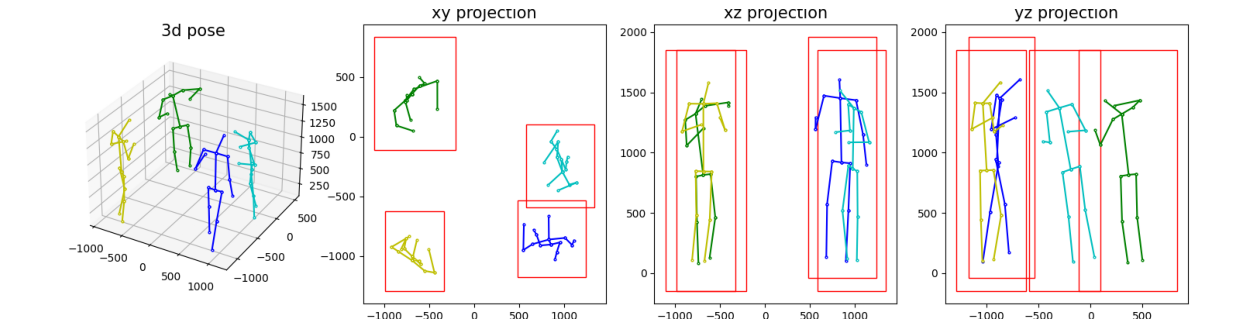

images with projected poses:


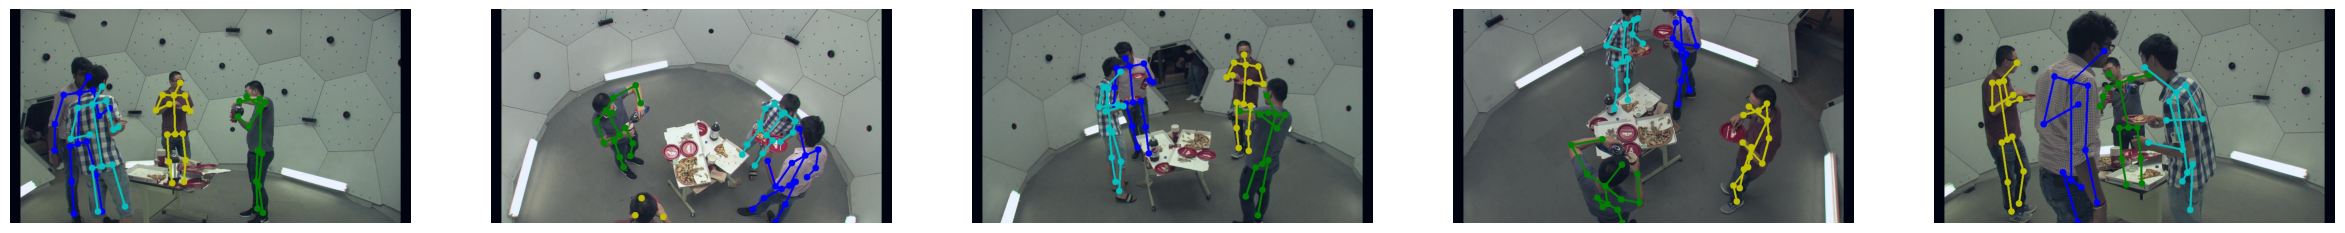

2d heatmaps prediction in view 1:


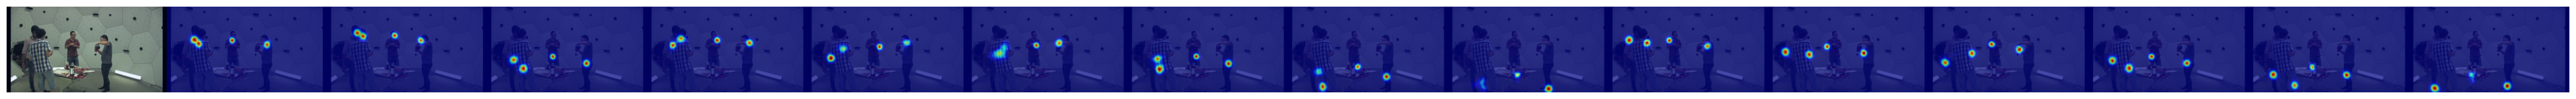

2d heatmaps prediction in view 2:


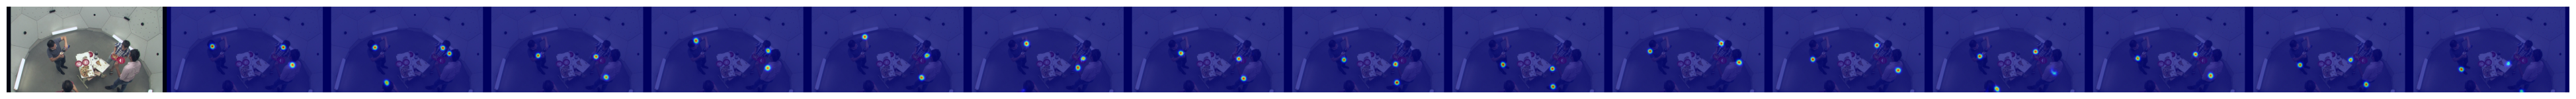

2d heatmaps prediction in view 3:


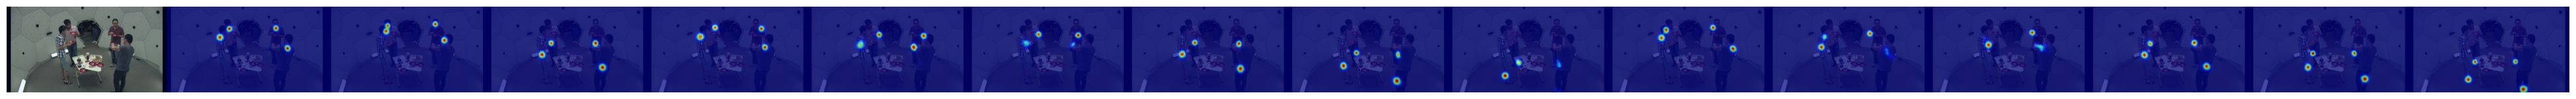

2d heatmaps prediction in view 4:


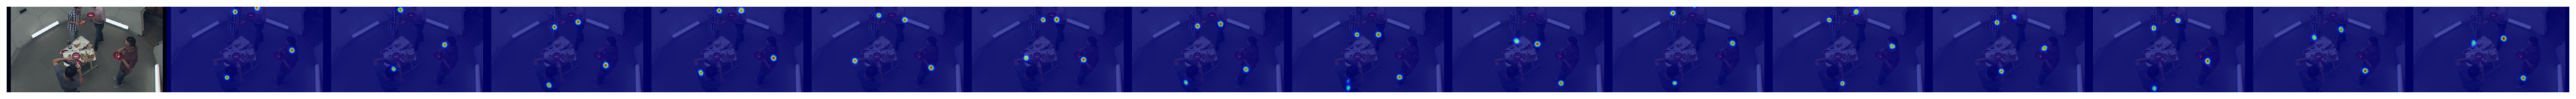

2d heatmaps prediction in view 5:


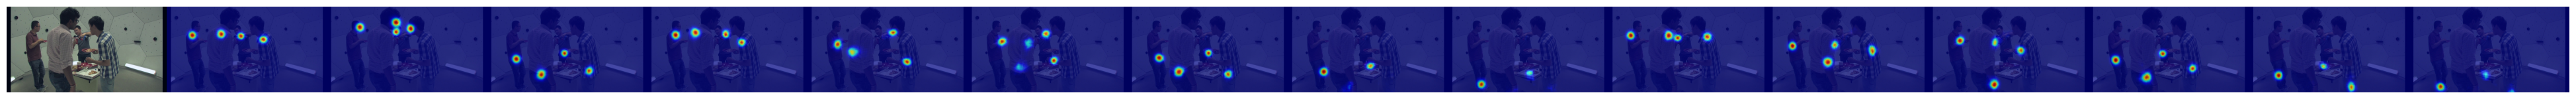

In [7]:
# plot the results
# visualize 2d planes
print("2d planes:")
plt.figure(figsize=(16, 10))
img = plt.imread(os.path.join(output_dir, '2d_planes', 'validation_00000000.png'))
plt.imshow(img)
plt.axis('off')
plt.show()

# visualize images with projected poses
print("images with projected poses:")
plt.figure(figsize=(30, 10))
for i in range(num_views):
    plt.subplot(1, num_views, i+1)
    img_path = os.path.join(output_dir, 'image_with_poses', 'validation_00000000_view_{}.jpg'.format(i+1))
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.axis('off')
plt.show()

# visualize 2d heatmaps prediction
for i in range(num_views):
    print("2d heatmaps prediction in view {}:".format(i+1))
    plt.figure(figsize=(50, 15))
    img_path = os.path.join(output_dir, 'heatmaps', 'validation_00000000_view_{}.jpg'.format(i+1))
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()